In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


# Global

Directly using local is sufficient

In [404]:
# stack_fixed = 'LM30'
stack_fixed = 'LM40'
# stack_fixed = 'LM30new'
# stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
# stack_fixed = 'LM48'

stack_moving = 'atlasV5'

In [405]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [406]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [407]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
    
print surround_weight, include_surround

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

In [408]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
# MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [409]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
#                                                       include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


(356, 427, 375)


Volume shape: (356, 427, 375)


In [410]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])

print volume_fixed[1].shape

(164, 113, 193)


Prior structure/index map not found. Generating a new one.
Volume shape: (164, 113, 193)


In [411]:
structure_subset = all_known_structures_sided

In [412]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [413]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [414]:
label_mapping_m2f

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [415]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [416]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [417]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [418]:
label_weights_m

{1: 1.0,
 2: 0.08578068878090006,
 3: 1.0,
 4: 0.15379052789032086,
 5: 1.0,
 6: 0.40870655618253604}

In [419]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [420]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['3N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [  94.00685547  151.00359631  176.50280962], centroid_f: [  85.10369128   30.99026846  161.16812081]


In [421]:
aligner.set_label_weights(label_weights=label_weights_m)

In [422]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [423]:
gradient_filepath_map_f

{1: '/home/yuncong/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/home/yuncong/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/home/yuncong/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/home/yuncong/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/home/yuncong/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/home/yuncong/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_SNR_L_surround_200_%(suffix)s.bp'}

In [424]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.050921 seconds
load gradient 2: 0.054065 seconds
load gradient 3: 0.055352 seconds
load gradient 4: 0.057265 seconds
load gradient 5: 0.063525 seconds
load gradient 6: 0.096091 seconds
overall: 0.377752 seconds


In [425]:
# aligner.grid_search(10)

In [426]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=100,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=1, lr2=.1,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
in T: 0.00 0.00 0.00, out T: 1.00 1.00 -1.00
step: 0.07 seconds
current score: -0.672849
new_T: [ 1.  1. -1.]
det: 1.10

iteration 1
in T: 1.00 1.00 -1.00, out T: 0.36 0.13 -0.45
step: 0.07 seconds
current score: -0.671306
new_T: [ 0.36336365  0.12751056 -0.4466329 ]
det: 1.01

iteration 2
in T: 0.36 0.13 -0.45, out T: 1.09 0.64 -1.16
step: 0.07 seconds
current score: -0.670944
new_T: [ 1.09343736  0.6434688  -1.1560638 ]
det: 1.06

iteration 3
in T: 1.09 0.64 -1.16, out T: 0.62 0.09 -0.60
step: 0.08 seconds
current score: -0.670731
new_T: [ 0.6182505   0.0887451  -0.59800082]
det: 1.01

iteration 4
in T: 0.62 0.09 -0.60, out T: 0.95 0.47 -0.96
step: 0.06 seconds
current score: -0.669798
new_T: [ 0.94849013  0.47201802 -0.96286119]
det: 1.06

iteration 5
in T: 0.95 0.47 -0.96, out T: 0.72 0.11 -0.55
step: 0.06 seconds
current score: -0.670171
new_T: [ 0.71720864  0.10643703 -0.54759064]
det: 1.02

iteration 6
in T: 0.72 0.11 -0.55, out T: 1.02 0.35 -0.84
step: 0.06 seconds

in T: 0.93 -0.07 -0.25, out T: 0.81 -0.18 -0.08
step: 0.07 seconds
current score: -0.669427
new_T: [ 0.80976471 -0.18422921 -0.08399221]
det: 0.99

iteration 53
in T: 0.81 -0.18 -0.08, out T: 0.88 -0.16 -0.20
step: 0.07 seconds
current score: -0.669350
new_T: [ 0.87995192 -0.1566767  -0.20236184]
det: 1.00

iteration 54
in T: 0.88 -0.16 -0.20, out T: 0.86 -0.12 -0.19
step: 0.07 seconds
current score: -0.669396
new_T: [ 0.85914764 -0.11743759 -0.19000277]
det: 1.01

iteration 55
in T: 0.86 -0.12 -0.19, out T: 0.90 -0.09 -0.17
step: 0.07 seconds
current score: -0.669362
new_T: [ 0.90149383 -0.08980536 -0.16872106]
det: 1.01

iteration 56
in T: 0.90 -0.09 -0.17, out T: 0.80 -0.17 -0.12
step: 0.07 seconds
current score: -0.669402
new_T: [ 0.80452858 -0.17468047 -0.11792239]
det: 1.01

iteration 57
in T: 0.80 -0.17 -0.12, out T: 0.89 -0.12 -0.21
step: 0.07 seconds
current score: -0.669370
new_T: [ 0.89107131 -0.11747705 -0.2074156 ]
det: 1.01

iteration 58
in T: 0.89 -0.12 -0.21, out T: 0.8

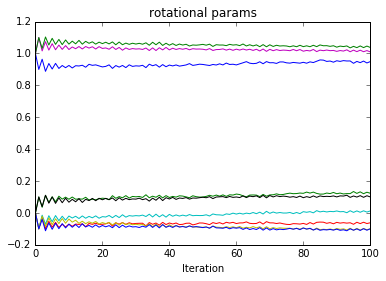

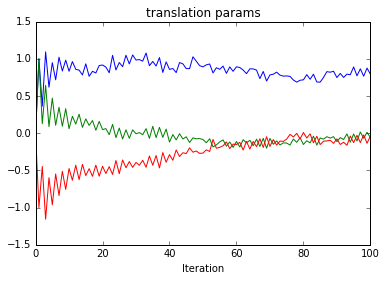

In [427]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.669174759292 -0.669280812936
[[ 0.94151525  0.12148745 -0.06817873  0.68638498]
 [ 0.00266569  1.01726408 -0.09602625 -0.12214642]
 [ 0.09688799 -0.096768    1.04244072 -0.00220757]]


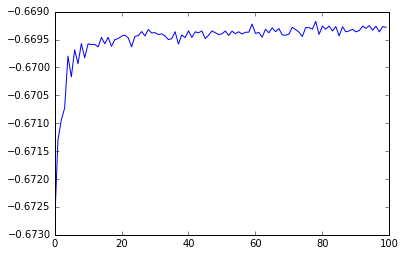

In [428]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [429]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [430]:
G_movingvol2fixedvol = consolidate(params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
print G_movingvol2fixedvol

[[  9.41515252e-01   1.21487449e-01  -6.81787307e-02  -9.03011610e+00]
 [  2.66568920e-03   1.01726408e+00  -9.60262525e-02  -1.06044103e+02]
 [  9.68879913e-02  -9.67680045e-02   1.04244072e+00  -1.73236219e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [431]:
def transform_volume_one_structure(structure):
    try:
        t = time.time()

#         vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32, prep_id=2, detector_id=detector_id)
        vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32,
                                                volume_type='score')

        volume_m_warped_inbbox, volume_m_warped_bbox_rel2movingvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())
        
        # Note: volume_m_warped_bbox_rel2movingvol is the same as volume_m_warped_bbox_rel2fixedvol.
        volume_m_warped_bbox_rel2fixedvol = volume_m_warped_bbox_rel2movingvol
        
        ######### Save volume ##########
        
        volume_m_warped_fp = \
        DataManager.get_transformed_volume_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_fp)
        bp.pack_ndarray_file(volume_m_warped_inbbox, volume_m_warped_fp)
        upload_to_s3(volume_m_warped_fp)
        
        ############### bbox #############
        volume_m_warped_bbox_fp = \
        DataManager.get_transformed_volume_bbox_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_bbox_fp)
        np.savetxt(volume_m_warped_bbox_fp, volume_m_warped_bbox_rel2fixedvol)
        upload_to_s3(volume_m_warped_bbox_fp)
            
        sys.stderr.write('Transform: %.2f seconds.\n' % (time.time() - t)) # 3s
    
    except Exception as e:
        sys.stderr.write('Error transforming volume %s: %s.\n' % (structure, e))

In [432]:
# for s in all_known_structures_sided_with_surround:
for s in ['3N_L', 'RMC_L', 'SNR_L', '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200']:
    transform_volume_one_structure(s)

aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_bbox.txt"


Transform: 3.85 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_bbox.txt"


Transform: 2.88 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_bbox.txt"


Transform: 3.16 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200_bbox.txt"


Transform: 2.71 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200_bbox.txt"


Transform: 3.49 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200_bbox.txt"


Transform: 5.32 seconds.


In [433]:
structure = 'SNR_L'

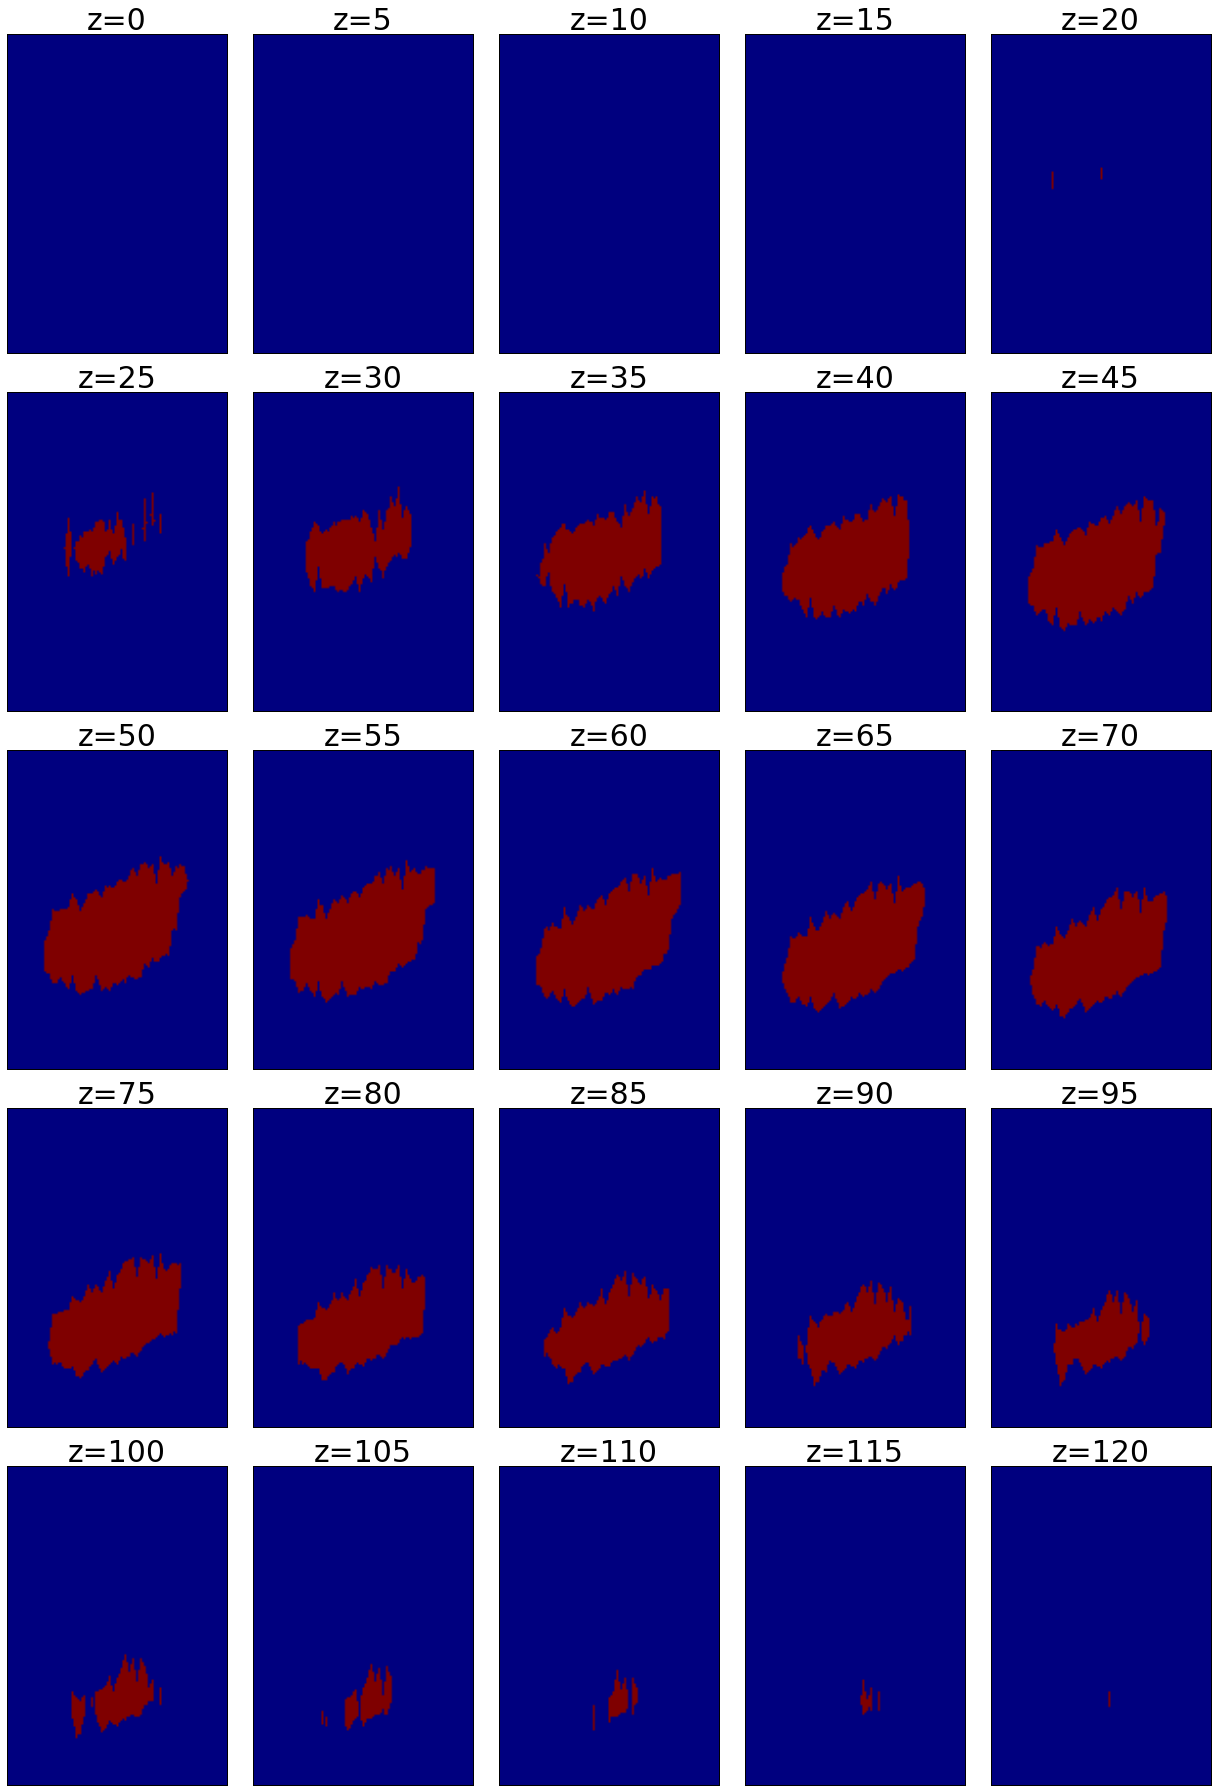

In [434]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [435]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

# volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
# transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

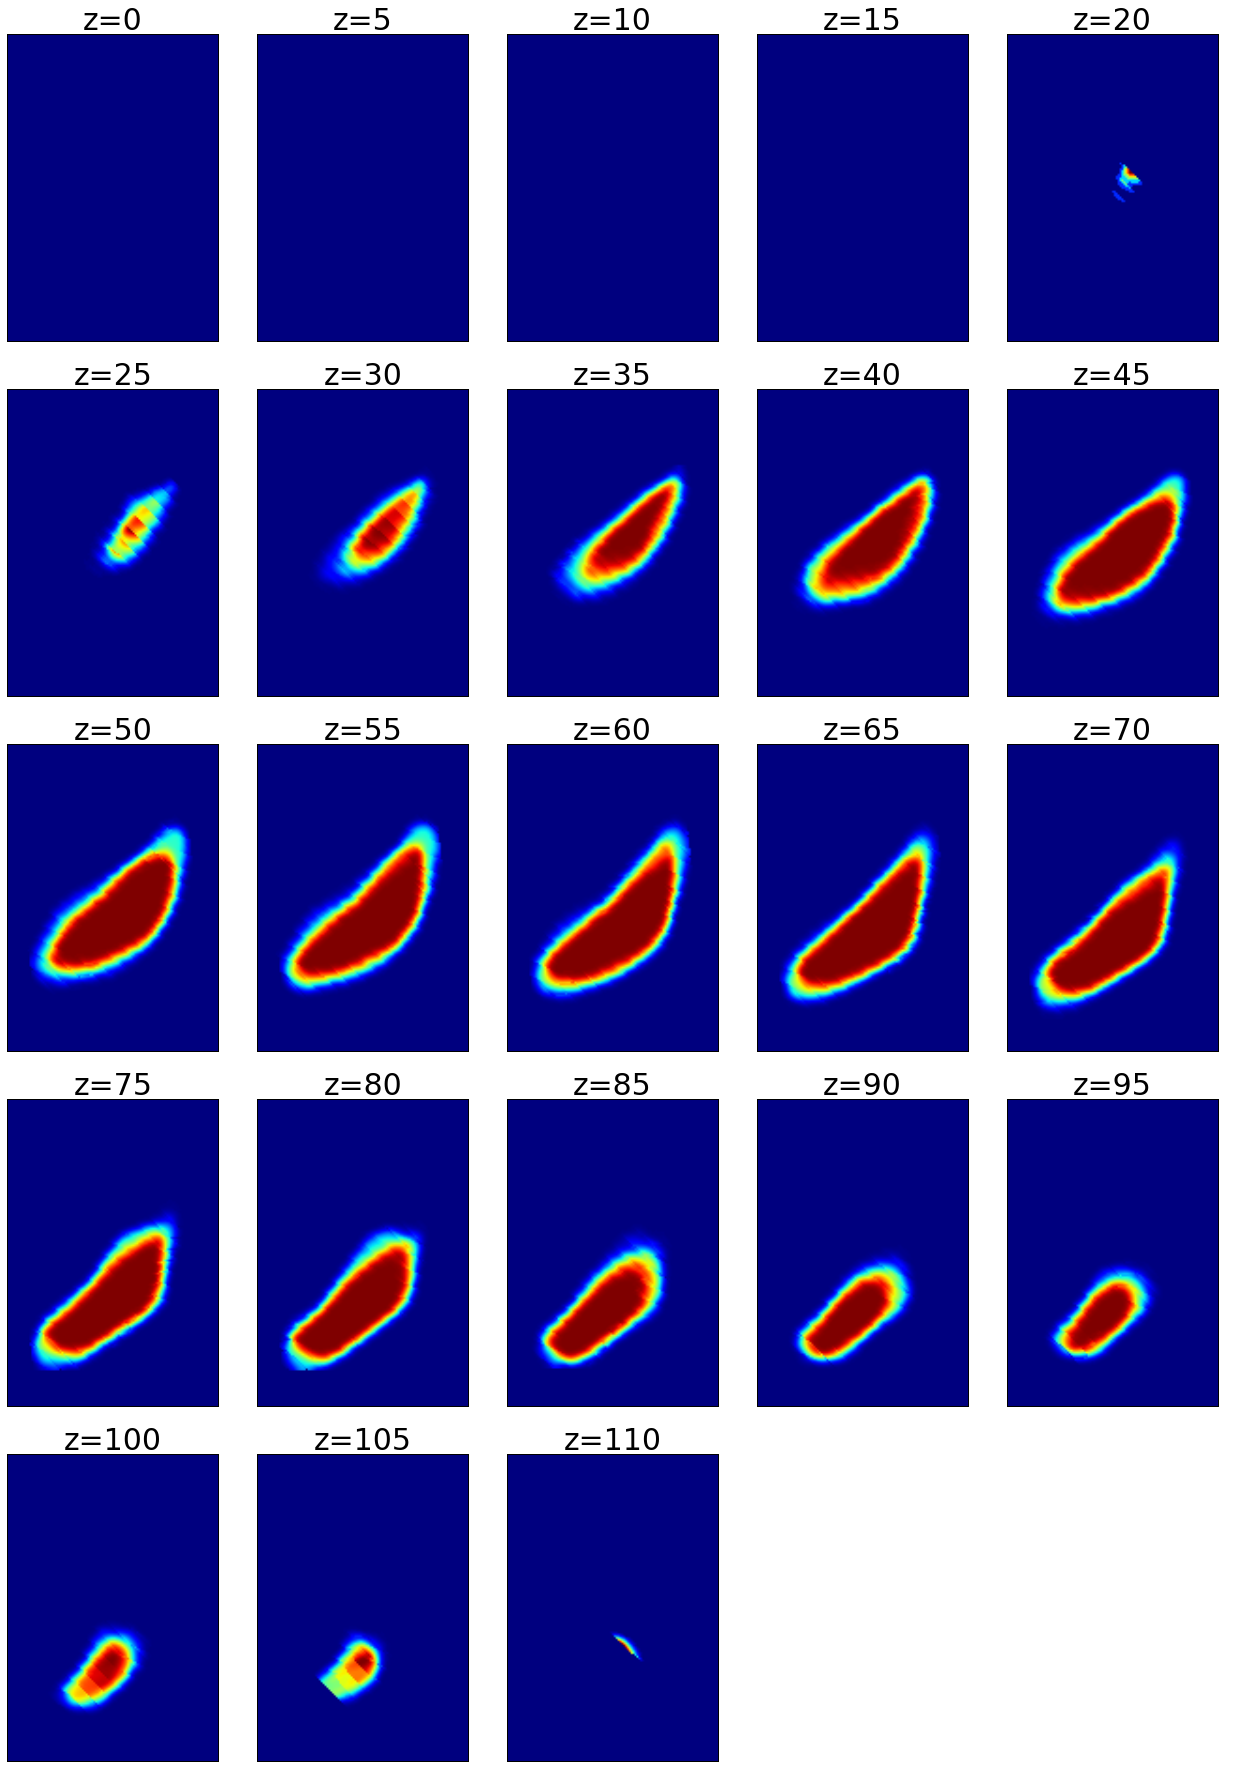

In [436]:
v_m2fg = \
crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

display_volume_sections(v_m2fg, start_level=0)

In [437]:
# Warping all structures.

volume_m2fg = {}
for label_m, vol_m in volume_moving.iteritems():
    
#     volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
#         transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

    volume_m2fg[label_m] = crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

# markers

In [438]:
marker_xyzs_rel2fixedsubj = {}
m = bp.unpack_ndarray_file('/home/yuncong/lauren_data/markers/%(stack)s/%(stack)s_markers_SNR_L.bp' % \
                           {'stack':stack_fixed})
for marker_id, marker_xyz in enumerate(m):
    marker_xyzs_rel2fixedsubj[marker_id] = marker_xyz
    

fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

marker_xyzs_rel2fixedvol = {k: m - fixedvol_bbox_rel2fixedsubj[[0,2,4]]
                                for k, m in marker_xyzs_rel2fixedsubj.iteritems()}

# draw

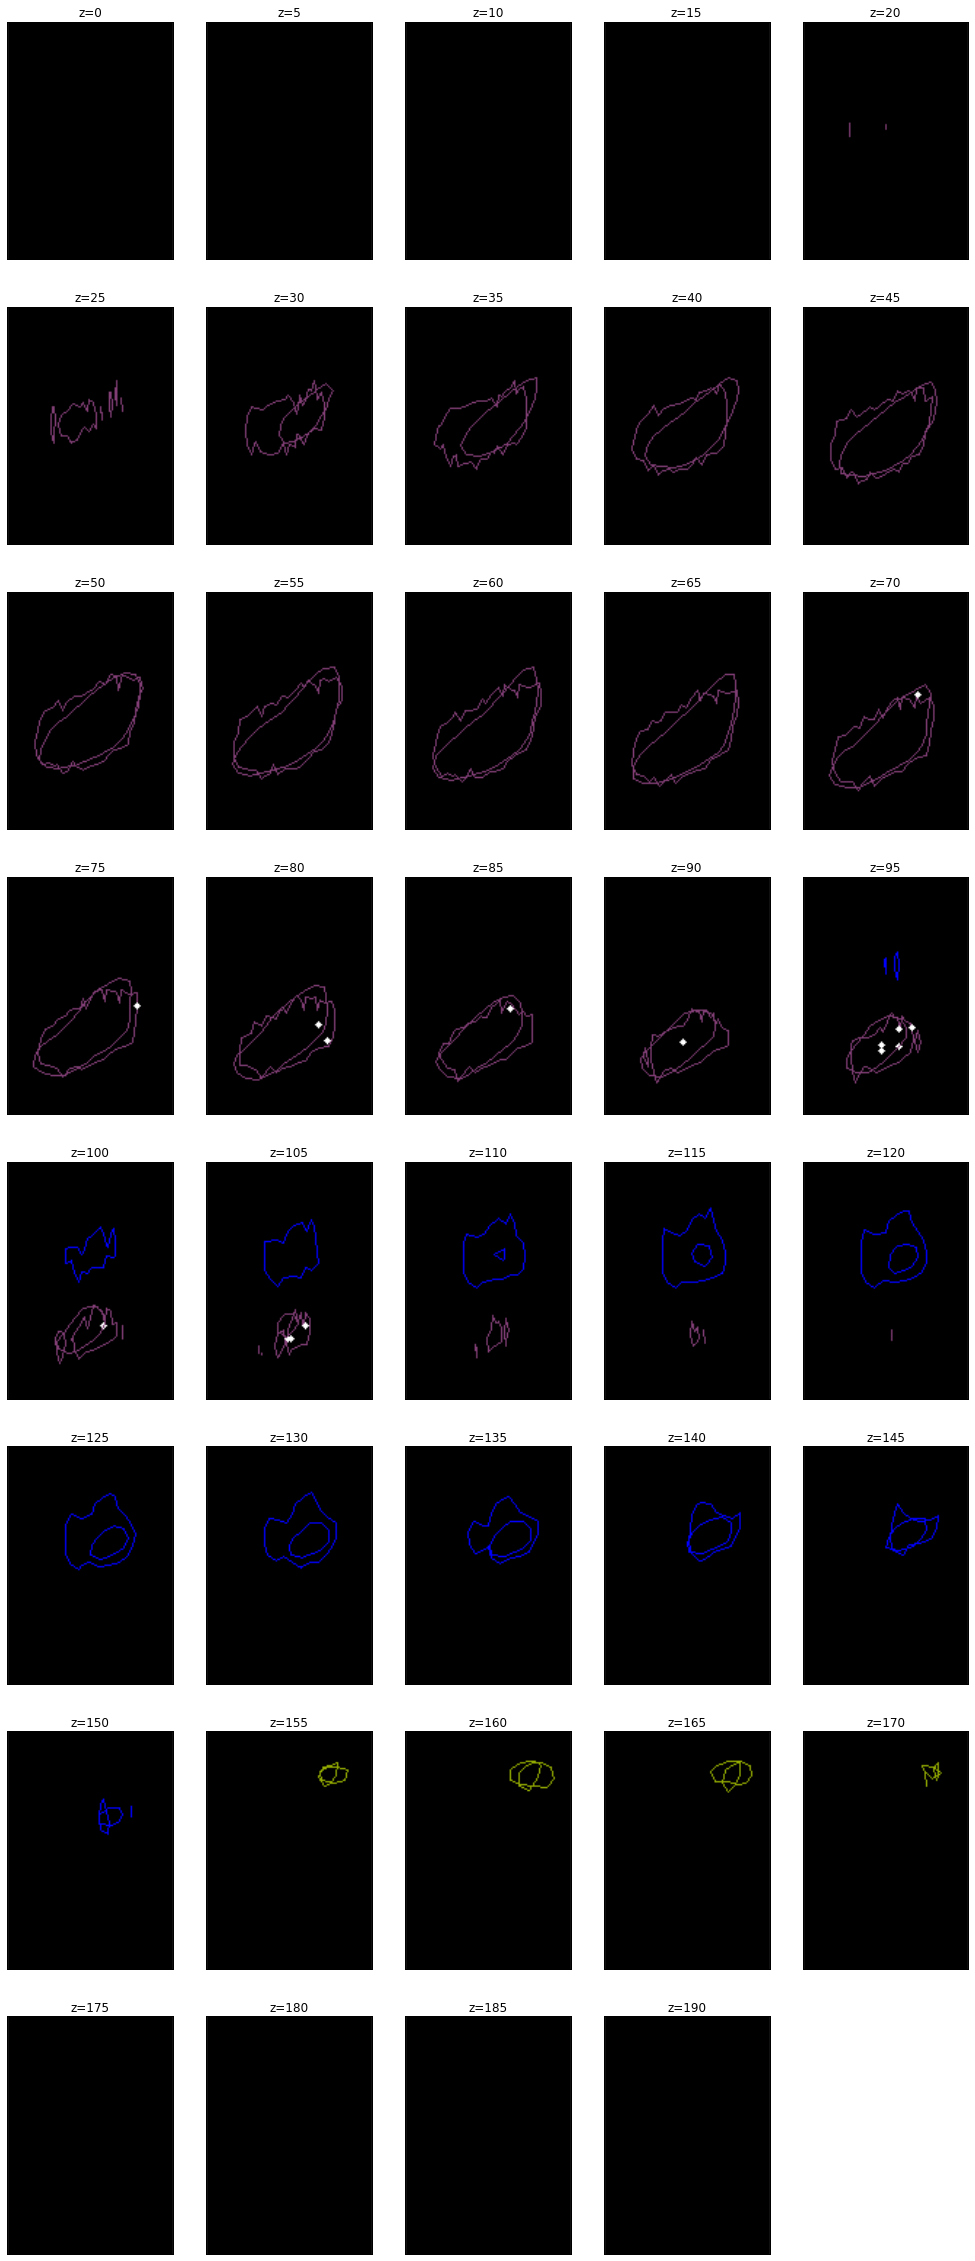

In [439]:
structures_to_draw = [l for l in volume_m2fg.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fg, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values())
              )

In [440]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_parameters.txt"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_scoreHistory.bp"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsSc

# Local

warp setting = 16 means directly rigidly register SNR_L with atlas SNR_L, taking surround into consideration.

In [441]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [442]:
# stack_fixed = 'LM30'
# stack_fixed = 'LM30new'
# stack_fixed = 'LM40'
# stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
# stack_fixed = 'LM48'

stack_moving = 'atlasV5'

In [443]:
warp_setting = 25

In [444]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                                                 24
transform_type                                                                rigid
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                       NaN
std_ty_um                                                                       NaN
std_tz_um                                                                       NaN
std_theta_xy_degree                                                             NaN
surround_weight                                                             inverse
regularization_weight                                                             0
comment                           local reg with surr no grid search; global

In [445]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
# MAX_GRID_SEARCH_ITER_NUM = 30

In [446]:
lr1 = 10
lr2 = 0.1

In [447]:
structure = 'SNR_L'

In [448]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (164, 113, 193)


In [449]:
print DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

[ -19   93 1132 1295 5923 6115]


In [450]:
# if include_surround:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                 structures=[structure, convert_to_surround_name(structure, margin='200')])
# else:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                                                  structures=[structure])

if include_surround:
    structures = [structure, convert_to_surround_name(structure, margin='200')]
else:
    structures = [structure]
    
volume_moving_in_bboxrel2fixedvol, volume_moving_bbox_rel2fixedvol, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_transformed_volume_all_known_structures_v2(stack_m=stack_moving, 
                                                         stack_f=stack_fixed,
                                                         warp_setting=24,
                                                         vol_type_f='annotationAsScore',
                                                         vol_type_m='score',
                            structures=[structure, convert_to_surround_name(structure, margin='200')],
                                                        return_label_mappings=True,
                                                         name_or_index_as_key='index',                                                               
                                                            common_shape=True)

print volume_moving_bbox_rel2fixedvol

[  10.  104.   35.  154.   11.  121.]


Prior structure/index map not found. Generating a new one.


In [451]:
# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving_in_bboxrel2fixedvol.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving_in_bboxrel2fixedvol[l] > cutoff), 
                                                  volume_moving_in_bboxrel2fixedvol.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [452]:
label_weights_m

{1: 1.0, 2: 0.40623702502775055}

In [453]:
aligner = Aligner4(volume_fixed, volume_moving_in_bboxrel2fixedvol, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 47.09196111  61.75020542  51.52767392], centroid_f: [ 55.08075023  98.82599761  61.5547493 ]


In [454]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [455]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])
load gradient 1: 0.130915 seconds
load gradient 2: 0.120742 seconds
overall: 0.251885 seconds


In [456]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
step: 0.34 seconds
current score: 0.226996
new_T: [ 0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
step: 0.33 seconds
current score: 0.227991
new_T: [ 1.60254167 -0.2647449   0.10472546]
det: 1.00

iteration 2
step: 0.34 seconds
current score: 0.229347
new_T: [ 1.60709668 -0.9978884   0.93405809]
det: 1.00

iteration 3
step: 0.34 seconds
current score: 0.229050
new_T: [ 1.92129166 -0.73988599  0.68319844]
det: 1.00

iteration 4
step: 0.34 seconds
current score: 0.231126
new_T: [ 1.91244245 -0.97935621  0.87725108]
det: 1.00

iteration 5
step: 0.33 seconds
current score: 0.229933
new_T: [ 2.0604773  -0.87557937  0.78899603]
det: 1.00

iteration 6
step: 0.29 seconds
current score: 0.230790
new_T: [ 2.06779795 -1.00304339  0.87830752]
det: 1.00

iteration 7
step: 0.21 seconds
current score: 0.230389
new_T: [ 2.13531813 -0.89887015  0.81426655]
det: 1.00

iteration 8
step: 0.19 seconds
current score: 0.231103
new_T: [ 2.10840661 -1.008773    0.89952459]
det: 1.00



step: 0.22 seconds
current score: 0.238630
new_T: [ 1.73909439 -0.75390027  0.78774823]
det: 1.00

iteration 75
step: 0.22 seconds
current score: 0.238692
new_T: [ 1.73495803 -0.75014247  0.78963899]
det: 1.00

iteration 76
step: 0.22 seconds
current score: 0.238782
new_T: [ 1.72495367 -0.75132761  0.79260266]
det: 1.00

iteration 77
step: 0.22 seconds
current score: 0.238845
new_T: [ 1.71633722 -0.75001568  0.79140551]
det: 1.00

iteration 78
step: 0.22 seconds
current score: 0.238930
new_T: [ 1.70681247 -0.74694832  0.79343981]
det: 1.00

iteration 79
step: 0.22 seconds
current score: 0.238991
new_T: [ 1.69324849 -0.74258013  0.78953423]
det: 1.00

iteration 80
step: 0.19 seconds
current score: 0.239053
new_T: [ 1.6847905  -0.73626316  0.78373087]
det: 1.00

iteration 81
step: 0.19 seconds
current score: 0.239115
new_T: [ 1.67338475 -0.73516408  0.7821752 ]
det: 1.00

iteration 82
step: 0.19 seconds
current score: 0.239178
new_T: [ 1.66567171 -0.73496532  0.77759816]
det: 1.00

itera

step: 0.20 seconds
current score: 0.242279
new_T: [ 1.6192288  -0.75636217  0.80404664]
det: 1.00

iteration 149
step: 0.19 seconds
current score: 0.242319
new_T: [ 1.61941529 -0.75695248  0.80557259]
det: 1.00

iteration 150
step: 0.19 seconds
current score: 0.242347
new_T: [ 1.61990653 -0.75474944  0.8040068 ]
det: 1.00

iteration 151
step: 0.19 seconds
current score: 0.242361
new_T: [ 1.61277496 -0.75440513  0.80779801]
det: 1.00

iteration 152
step: 0.19 seconds
current score: 0.242393
new_T: [ 1.60777123 -0.74922969  0.80938225]
det: 1.00

iteration 153
step: 0.19 seconds
current score: 0.242420
new_T: [ 1.60815257 -0.75205364  0.8163739 ]
det: 1.00

iteration 154
step: 0.19 seconds
current score: 0.242449
new_T: [ 1.61014049 -0.74928392  0.8174115 ]
det: 1.00

iteration 155
step: 0.19 seconds
current score: 0.242480
new_T: [ 1.60802001 -0.75487505  0.82111136]
det: 1.00

iteration 156
step: 0.19 seconds
current score: 0.242509
new_T: [ 1.61035648 -0.7554501   0.82114764]
det: 1.0

step: 0.33 seconds
current score: 0.244210
new_T: [ 1.40117385 -0.72325811  0.90954444]
det: 1.00

iteration 222
step: 0.33 seconds
current score: 0.244230
new_T: [ 1.40186117 -0.72021139  0.90804433]
det: 1.00

iteration 223
step: 0.32 seconds
current score: 0.244248
new_T: [ 1.40705321 -0.72074823  0.91090176]
det: 1.00

iteration 224
step: 0.33 seconds
current score: 0.244262
new_T: [ 1.41281788 -0.71969084  0.90770456]
det: 1.00

iteration 225
step: 0.34 seconds
current score: 0.244289
new_T: [ 1.41577176 -0.72562491  0.91081686]
det: 1.00

iteration 226
step: 0.33 seconds
current score: 0.244325
new_T: [ 1.4239203 -0.7219232  0.9024608]
det: 1.00

iteration 227
step: 0.31 seconds
current score: 0.244345
new_T: [ 1.41739955 -0.72904149  0.91171184]
det: 1.00

iteration 228
step: 0.31 seconds
current score: 0.244370
new_T: [ 1.421514   -0.72311022  0.90948386]
det: 1.00

iteration 229
step: 0.31 seconds
current score: 0.244386
new_T: [ 1.42230163 -0.72665592  0.91919035]
det: 1.00



step: 0.31 seconds
current score: 0.245417
new_T: [ 1.37397939 -0.69930596  1.04962317]
det: 1.00

iteration 295
step: 0.34 seconds
current score: 0.245433
new_T: [ 1.37403668 -0.70090629  1.05117953]
det: 1.00

iteration 296
step: 0.32 seconds
current score: 0.245457
new_T: [ 1.37606266 -0.69878674  1.0480654 ]
det: 1.00

iteration 297
step: 0.27 seconds
current score: 0.245456
new_T: [ 1.37563772 -0.69766018  1.05144916]
det: 1.00

iteration 298
step: 0.21 seconds
current score: 0.245481
new_T: [ 1.37626938 -0.69750805  1.04906356]
det: 1.00

iteration 299
step: 0.20 seconds
current score: 0.245488
new_T: [ 1.38050235 -0.69828222  1.04417561]
det: 1.00

iteration 300
step: 0.19 seconds
current score: 0.245502
new_T: [ 1.37904575 -0.70356039  1.04390145]
det: 1.00

iteration 301
step: 0.19 seconds
current score: 0.245520
new_T: [ 1.37782884 -0.70416438  1.03360335]
det: 1.00

iteration 302
step: 0.19 seconds
current score: 0.245543
new_T: [ 1.37132763 -0.70846202  1.028059  ]
det: 1.0

step: 0.21 seconds
current score: 0.246122
new_T: [ 1.25653462 -0.6802734   1.09681851]
det: 1.00

iteration 368
step: 0.19 seconds
current score: 0.246123
new_T: [ 1.25796037 -0.67735688  1.10231026]
det: 1.00

iteration 369
step: 0.19 seconds
current score: 0.246130
new_T: [ 1.25716916 -0.67200916  1.1054233 ]
det: 1.00

iteration 370
step: 0.19 seconds
current score: 0.246138
new_T: [ 1.25955797 -0.66511457  1.1054559 ]
det: 1.00

iteration 371
step: 0.19 seconds
current score: 0.246145
new_T: [ 1.25346171 -0.66212721  1.1074869 ]
det: 1.00

iteration 372
step: 0.19 seconds
current score: 0.246147
new_T: [ 1.25391728 -0.66197456  1.10906733]
det: 1.00

iteration 373
step: 0.19 seconds
current score: 0.246159
new_T: [ 1.25499096 -0.6591324   1.10927008]
det: 1.00

iteration 374
step: 0.19 seconds
current score: 0.246147
new_T: [ 1.25712236 -0.65469781  1.10987444]
det: 1.00

iteration 375
step: 0.19 seconds
current score: 0.246161
new_T: [ 1.25647893 -0.65694924  1.11403199]
det: 1.0

step: 0.22 seconds
current score: 0.246679
new_T: [ 1.23574164 -0.60968997  1.20155587]
det: 1.00

iteration 441
step: 0.20 seconds
current score: 0.246688
new_T: [ 1.23138824 -0.60845072  1.20520619]
det: 1.00

iteration 442
step: 0.21 seconds
current score: 0.246685
new_T: [ 1.22965624 -0.60711823  1.2075588 ]
det: 1.00

iteration 443
step: 0.21 seconds
current score: 0.246691
new_T: [ 1.22744148 -0.60641287  1.20785803]
det: 1.00

iteration 444
step: 0.22 seconds
current score: 0.246696
new_T: [ 1.22455129 -0.60762635  1.20831413]
det: 1.00

iteration 445
step: 0.23 seconds
current score: 0.246701
new_T: [ 1.22520314 -0.6101089   1.21055276]
det: 1.00

iteration 446
step: 0.21 seconds
current score: 0.246703
new_T: [ 1.22039174 -0.60926908  1.2125235 ]
det: 1.00

iteration 447
step: 0.23 seconds
current score: 0.246708
new_T: [ 1.21583171 -0.6064489   1.21238333]
det: 1.00

iteration 448
step: 0.36 seconds
current score: 0.246703
new_T: [ 1.21429253 -0.60419367  1.20890218]
det: 1.0

step: 0.36 seconds
current score: 0.246979
new_T: [ 1.16590015 -0.61449413  1.2027746 ]
det: 1.00

iteration 514
step: 0.32 seconds
current score: 0.246976
new_T: [ 1.16650003 -0.613676    1.19874907]
det: 1.00

iteration 515
step: 0.32 seconds
current score: 0.246981
new_T: [ 1.16398529 -0.61656465  1.20208281]
det: 1.00

iteration 516
step: 0.31 seconds
current score: 0.246972
new_T: [ 1.1604862  -0.61605078  1.19824729]
det: 1.00

iteration 517
step: 0.31 seconds
current score: 0.246971
new_T: [ 1.15621422 -0.61726701  1.2035415 ]
det: 1.00

iteration 518
step: 0.31 seconds
current score: 0.246975
new_T: [ 1.15606746 -0.6135393   1.20622549]
det: 1.00

iteration 519
step: 0.36 seconds
current score: 0.246981
new_T: [ 1.15664955 -0.61210348  1.2113273 ]
det: 1.00

iteration 520
step: 0.37 seconds
current score: 0.246973
new_T: [ 1.15710758 -0.61059637  1.213203  ]
det: 1.00

iteration 521
step: 0.34 seconds
current score: 0.246983
new_T: [ 1.15595261 -0.60751043  1.21441554]
det: 1.0

step: 0.31 seconds
current score: 0.247186
new_T: [ 1.09791495 -0.60798021  1.23160361]
det: 1.00

iteration 587
step: 0.31 seconds
current score: 0.247184
new_T: [ 1.09590266 -0.61139046  1.22879386]
det: 1.00

iteration 588
step: 0.32 seconds
current score: 0.247195
new_T: [ 1.09634732 -0.61399717  1.22625011]
det: 1.00

iteration 589
step: 0.31 seconds
current score: 0.247205
new_T: [ 1.09789498 -0.61610727  1.22333601]
det: 1.00

iteration 590
step: 0.31 seconds
current score: 0.247216
new_T: [ 1.09953147 -0.61637703  1.22299264]
det: 1.00

iteration 591
step: 0.32 seconds
current score: 0.247224
new_T: [ 1.10200268 -0.61843157  1.22234707]
det: 1.00

iteration 592
step: 0.22 seconds
current score: 0.247223
new_T: [ 1.10579481 -0.61895545  1.22070236]
det: 1.00

iteration 593
step: 0.22 seconds
current score: 0.247226
new_T: [ 1.10676826 -0.61803333  1.22157622]
det: 1.00

iteration 594
step: 0.22 seconds
current score: 0.247224
new_T: [ 1.10769182 -0.61730358  1.22790611]
det: 1.0

step: 0.38 seconds
current score: 0.247335
new_T: [ 1.13000372 -0.63066805  1.22283657]
det: 1.00

iteration 660
step: 0.39 seconds
current score: 0.247332
new_T: [ 1.13138311 -0.63162073  1.22208483]
det: 1.00

iteration 661
step: 0.39 seconds
current score: 0.247334
new_T: [ 1.13193435 -0.6349637   1.22327533]
det: 1.00

iteration 662
step: 0.39 seconds
current score: 0.247337
new_T: [ 1.13056761 -0.63363764  1.21942559]
det: 1.00

iteration 663
step: 0.39 seconds
current score: 0.247340
new_T: [ 1.12972737 -0.6354967   1.22028624]
det: 1.00

iteration 664
step: 0.39 seconds
current score: 0.247344
new_T: [ 1.12849466 -0.6372239   1.22032144]
det: 1.00

iteration 665
step: 0.38 seconds
current score: 0.247343
new_T: [ 1.12783821 -0.63547913  1.2165133 ]
det: 1.00

iteration 666
step: 0.38 seconds
current score: 0.247344
new_T: [ 1.12832168 -0.63708826  1.21314777]
det: 1.00

iteration 667
step: 0.32 seconds
current score: 0.247354
new_T: [ 1.12128829 -0.64073039  1.21466178]
det: 1.0

step: 0.19 seconds
current score: 0.247378
new_T: [ 1.11273232 -0.64336508  1.23141782]
det: 1.00

iteration 733
step: 0.19 seconds
current score: 0.247379
new_T: [ 1.11128389 -0.64321328  1.23017841]
det: 1.00

iteration 734
step: 0.19 seconds
current score: 0.247374
new_T: [ 1.11051695 -0.64410768  1.23072759]
det: 1.00

iteration 735
step: 0.19 seconds
current score: 0.247377
new_T: [ 1.10907963 -0.6428087   1.22870796]
det: 1.00

iteration 736
step: 0.19 seconds
current score: 0.247377
new_T: [ 1.10690612 -0.64264054  1.22820679]
det: 1.00

iteration 737
step: 0.19 seconds
current score: 0.247379
new_T: [ 1.1057104  -0.64413305  1.22953241]
det: 1.00

iteration 738
step: 0.19 seconds
current score: 0.247381
new_T: [ 1.10562196 -0.64257665  1.22782535]
det: 1.00

iteration 739
step: 0.19 seconds
current score: 0.247376
new_T: [ 1.10597332 -0.6448006   1.22741553]
det: 1.00

iteration 740
step: 0.19 seconds
current score: 0.247383
new_T: [ 1.10581645 -0.64601116  1.22611908]
det: 1.0

step: 0.17 seconds
current score: 0.247436
new_T: [ 1.07385832 -0.65283051  1.21689403]
det: 1.00

iteration 807
step: 0.17 seconds
current score: 0.247438
new_T: [ 1.07361489 -0.65298767  1.21618314]
det: 1.00

iteration 808
step: 0.18 seconds
current score: 0.247437
new_T: [ 1.07302019 -0.65244319  1.21494646]
det: 1.00

iteration 809
step: 0.18 seconds
current score: 0.247434
new_T: [ 1.07045897 -0.65448131  1.21535371]
det: 1.00

iteration 810
step: 0.20 seconds
current score: 0.247434
new_T: [ 1.06927629 -0.65287883  1.21473029]
det: 1.00

iteration 811
step: 0.19 seconds
current score: 0.247438
new_T: [ 1.06651631 -0.65576682  1.21463265]
det: 1.00

iteration 812
step: 0.19 seconds
current score: 0.247441
new_T: [ 1.06811258 -0.65265678  1.21461874]
det: 1.00

iteration 813
step: 0.19 seconds
current score: 0.247446
new_T: [ 1.06641507 -0.65634888  1.21676511]
det: 1.00

iteration 814
step: 0.19 seconds
current score: 0.247441
new_T: [ 1.06623449 -0.65169704  1.21370178]
det: 1.0

step: 0.17 seconds
current score: 0.247478
new_T: [ 1.06947587 -0.64744984  1.22675374]
det: 1.00

iteration 881
step: 0.17 seconds
current score: 0.247477
new_T: [ 1.06968997 -0.64721322  1.22514106]
det: 1.00

iteration 882
step: 0.17 seconds
current score: 0.247473
new_T: [ 1.0685801  -0.64740099  1.22457465]
det: 1.00

iteration 883
step: 0.17 seconds
current score: 0.247475
new_T: [ 1.06950731 -0.64542653  1.22361339]
det: 1.00

iteration 884
step: 0.17 seconds
current score: 0.247465
new_T: [ 1.06891458 -0.64419437  1.22380437]
det: 1.00

iteration 885
step: 0.17 seconds
current score: 0.247465
new_T: [ 1.06808769 -0.64405332  1.2246248 ]
det: 1.00

iteration 886
step: 0.17 seconds
current score: 0.247463
new_T: [ 1.06841823 -0.64326872  1.22574993]
det: 1.00

iteration 887
step: 0.17 seconds
current score: 0.247466
new_T: [ 1.06933845 -0.64345796  1.22619385]
det: 1.00

iteration 888
step: 0.17 seconds
current score: 0.247464
new_T: [ 1.06941059 -0.6438531   1.22757073]
det: 1.0

step: 0.19 seconds
current score: 0.247498
new_T: [ 1.07409139 -0.65721031  1.21314821]
det: 1.00

iteration 955
step: 0.19 seconds
current score: 0.247493
new_T: [ 1.07300354 -0.65511734  1.20988093]
det: 1.00

iteration 956
step: 0.19 seconds
current score: 0.247492
new_T: [ 1.07123144 -0.65432132  1.21035323]
det: 1.00

iteration 957
step: 0.19 seconds
current score: 0.247490
new_T: [ 1.07064164 -0.65286532  1.20948215]
det: 1.00

iteration 958
step: 0.19 seconds
current score: 0.247490
new_T: [ 1.06827185 -0.65590423  1.20664698]
det: 1.00

iteration 959
step: 0.19 seconds
current score: 0.247491
new_T: [ 1.07249067 -0.65445762  1.20427085]
det: 1.00

iteration 960
step: 0.19 seconds
current score: 0.247496
new_T: [ 1.07192176 -0.65732829  1.20316738]
det: 1.00

iteration 961
step: 0.19 seconds
current score: 0.247501
new_T: [ 1.07378585 -0.65755763  1.19994873]
det: 1.00

iteration 962
step: 0.19 seconds
current score: 0.247507
new_T: [ 1.07271885 -0.65935812  1.2024468 ]
det: 1.0

step: 0.17 seconds
current score: 0.247524
new_T: [ 1.06733111 -0.67594712  1.18132664]
det: 1.00

iteration 1029
step: 0.17 seconds
current score: 0.247524
new_T: [ 1.06858366 -0.67733618  1.18026358]
det: 1.00

iteration 1030
step: 0.17 seconds
current score: 0.247524
new_T: [ 1.06812456 -0.67847002  1.1796157 ]
det: 1.00

iteration 1031
step: 0.17 seconds
current score: 0.247527
new_T: [ 1.06764171 -0.67940623  1.17845709]
det: 1.00

iteration 1032
step: 0.17 seconds
current score: 0.247528
new_T: [ 1.06839082 -0.67964579  1.17689207]
det: 1.00

iteration 1033
step: 0.17 seconds
current score: 0.247529
new_T: [ 1.06730738 -0.68041272  1.17733806]
det: 1.00

iteration 1034
step: 0.18 seconds
current score: 0.247535
new_T: [ 1.06571003 -0.67952514  1.17432641]
det: 1.00

iteration 1035
step: 0.19 seconds
current score: 0.247532
new_T: [ 1.06598376 -0.67917498  1.17361022]
det: 1.00

iteration 1036
step: 0.19 seconds
current score: 0.247532
new_T: [ 1.0650481  -0.67822256  1.1721118 ]


step: 0.39 seconds
current score: 0.247530
new_T: [ 1.04673818 -0.67787169  1.18243649]
det: 1.00

iteration 1101
step: 0.38 seconds
current score: 0.247531
new_T: [ 1.04690867 -0.67681655  1.18198204]
det: 1.00

iteration 1102
step: 0.39 seconds
current score: 0.247528
new_T: [ 1.04648232 -0.67731761  1.18195358]
det: 1.00

iteration 1103
step: 0.39 seconds
current score: 0.247531
new_T: [ 1.04602835 -0.67737889  1.18220802]
det: 1.00

iteration 1104
step: 0.39 seconds
current score: 0.247528
new_T: [ 1.04597646 -0.67771247  1.18231506]
det: 1.00

iteration 1105
step: 0.39 seconds
current score: 0.247526
new_T: [ 1.04638885 -0.67817511  1.18294627]
det: 1.00

iteration 1106
step: 0.39 seconds
current score: 0.247520
new_T: [ 1.04627903 -0.67985568  1.182845  ]
det: 1.00

iteration 1107
step: 0.39 seconds
current score: 0.247527
new_T: [ 1.04683227 -0.68018245  1.18200032]
det: 1.00

iteration 1108
step: 0.39 seconds
current score: 0.247528
new_T: [ 1.04798072 -0.68074441  1.18173354]


step: 0.19 seconds
current score: 0.247538
new_T: [ 1.04529265 -0.68371655  1.20176033]
det: 1.00

iteration 1173
step: 0.19 seconds
current score: 0.247524
new_T: [ 1.04829455 -0.67843498  1.19535037]
det: 1.00

iteration 1174
step: 0.19 seconds
current score: 0.247530
new_T: [ 1.04234964 -0.68213438  1.20163834]
det: 1.00

iteration 1175
step: 0.19 seconds
current score: 0.247531
new_T: [ 1.04508566 -0.67766891  1.19532773]
det: 1.00

iteration 1176
step: 0.19 seconds
current score: 0.247535
new_T: [ 1.04026446 -0.68148556  1.20138731]
det: 1.00

iteration 1177
step: 0.19 seconds
current score: 0.247528
new_T: [ 1.04236651 -0.67773399  1.19467481]
det: 1.00

iteration 1178
step: 0.19 seconds
current score: 0.247531
new_T: [ 1.03890925 -0.68155214  1.19881285]
det: 1.00

iteration 1179
step: 0.19 seconds
current score: 0.247527
new_T: [ 1.04021781 -0.6789085   1.1937617 ]
det: 1.00

iteration 1180
step: 0.19 seconds
current score: 0.247527
new_T: [ 1.03840356 -0.6811473   1.19571578]


step: 0.17 seconds
current score: 0.247533
new_T: [ 1.03167449 -0.66526821  1.22232694]
det: 1.00

iteration 1245
step: 0.17 seconds
current score: 0.247534
new_T: [ 1.03419884 -0.66389548  1.22089154]
det: 1.00

iteration 1246
step: 0.17 seconds
current score: 0.247530
new_T: [ 1.03324762 -0.66559737  1.22475029]
det: 1.00

iteration 1247
step: 0.17 seconds
current score: 0.247535
new_T: [ 1.03417614 -0.6629703   1.22260739]
det: 1.00

iteration 1248
step: 0.17 seconds
current score: 0.247530
new_T: [ 1.03402946 -0.66404289  1.22511943]
det: 1.00

iteration 1249
step: 0.16 seconds
current score: 0.247534
new_T: [ 1.03449786 -0.66307043  1.22655112]
det: 1.00

iteration 1250
step: 0.16 seconds
current score: 0.247532
new_T: [ 1.03595783 -0.6631718   1.22816668]
det: 1.00

iteration 1251
step: 0.15 seconds
current score: 0.247535
new_T: [ 1.0359031  -0.66549263  1.22931685]
det: 1.00

iteration 1252
step: 0.16 seconds
current score: 0.247538
new_T: [ 1.0369495  -0.66371506  1.22851713]


step: 0.21 seconds
current score: 0.247542
new_T: [ 1.04017377 -0.67152402  1.21256036]
det: 1.00

iteration 1317
step: 0.19 seconds
current score: 0.247540
new_T: [ 1.04124974 -0.67108043  1.21178591]
det: 1.00

iteration 1318
step: 0.19 seconds
current score: 0.247542
new_T: [ 1.03864855 -0.67225462  1.21426538]
det: 1.00

iteration 1319
step: 0.19 seconds
current score: 0.247543
new_T: [ 1.03962946 -0.6711836   1.2116359 ]
det: 1.00

iteration 1320
step: 0.19 seconds
current score: 0.247546
new_T: [ 1.03973061 -0.67212937  1.21140584]
det: 1.00

iteration 1321
step: 0.19 seconds
current score: 0.247544
new_T: [ 1.03945591 -0.67154027  1.21096159]
det: 1.00

iteration 1322
step: 0.19 seconds
current score: 0.247543
new_T: [ 1.03872564 -0.67107268  1.21146245]
det: 1.00

iteration 1323
step: 0.19 seconds
current score: 0.247543
new_T: [ 1.03858005 -0.67137054  1.21203601]
det: 1.00

iteration 1324
step: 0.19 seconds
current score: 0.247543
new_T: [ 1.03874769 -0.67068531  1.21209458]


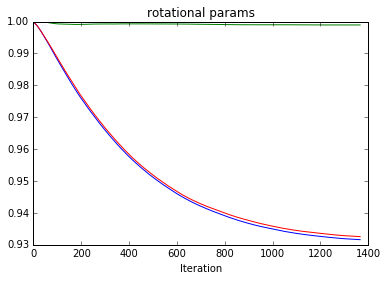

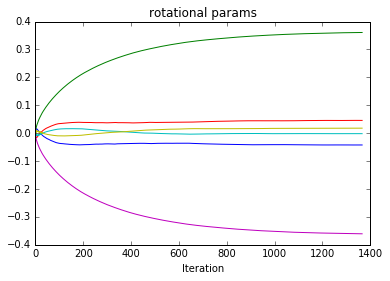

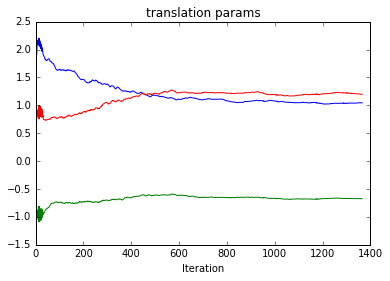

In [457]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.24755119902 0.247542228799
[[ 0.93169189 -0.0422245   0.36078707  1.04295205]
 [ 0.0458765   0.9989459  -0.00155985 -0.67196783]
 [-0.3603409   0.01800495  0.93264691  1.2050819 ]]


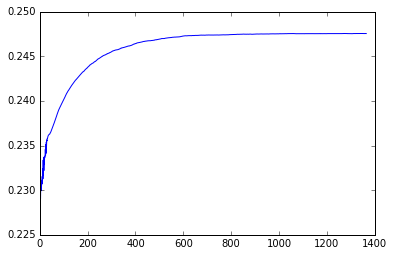

In [458]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

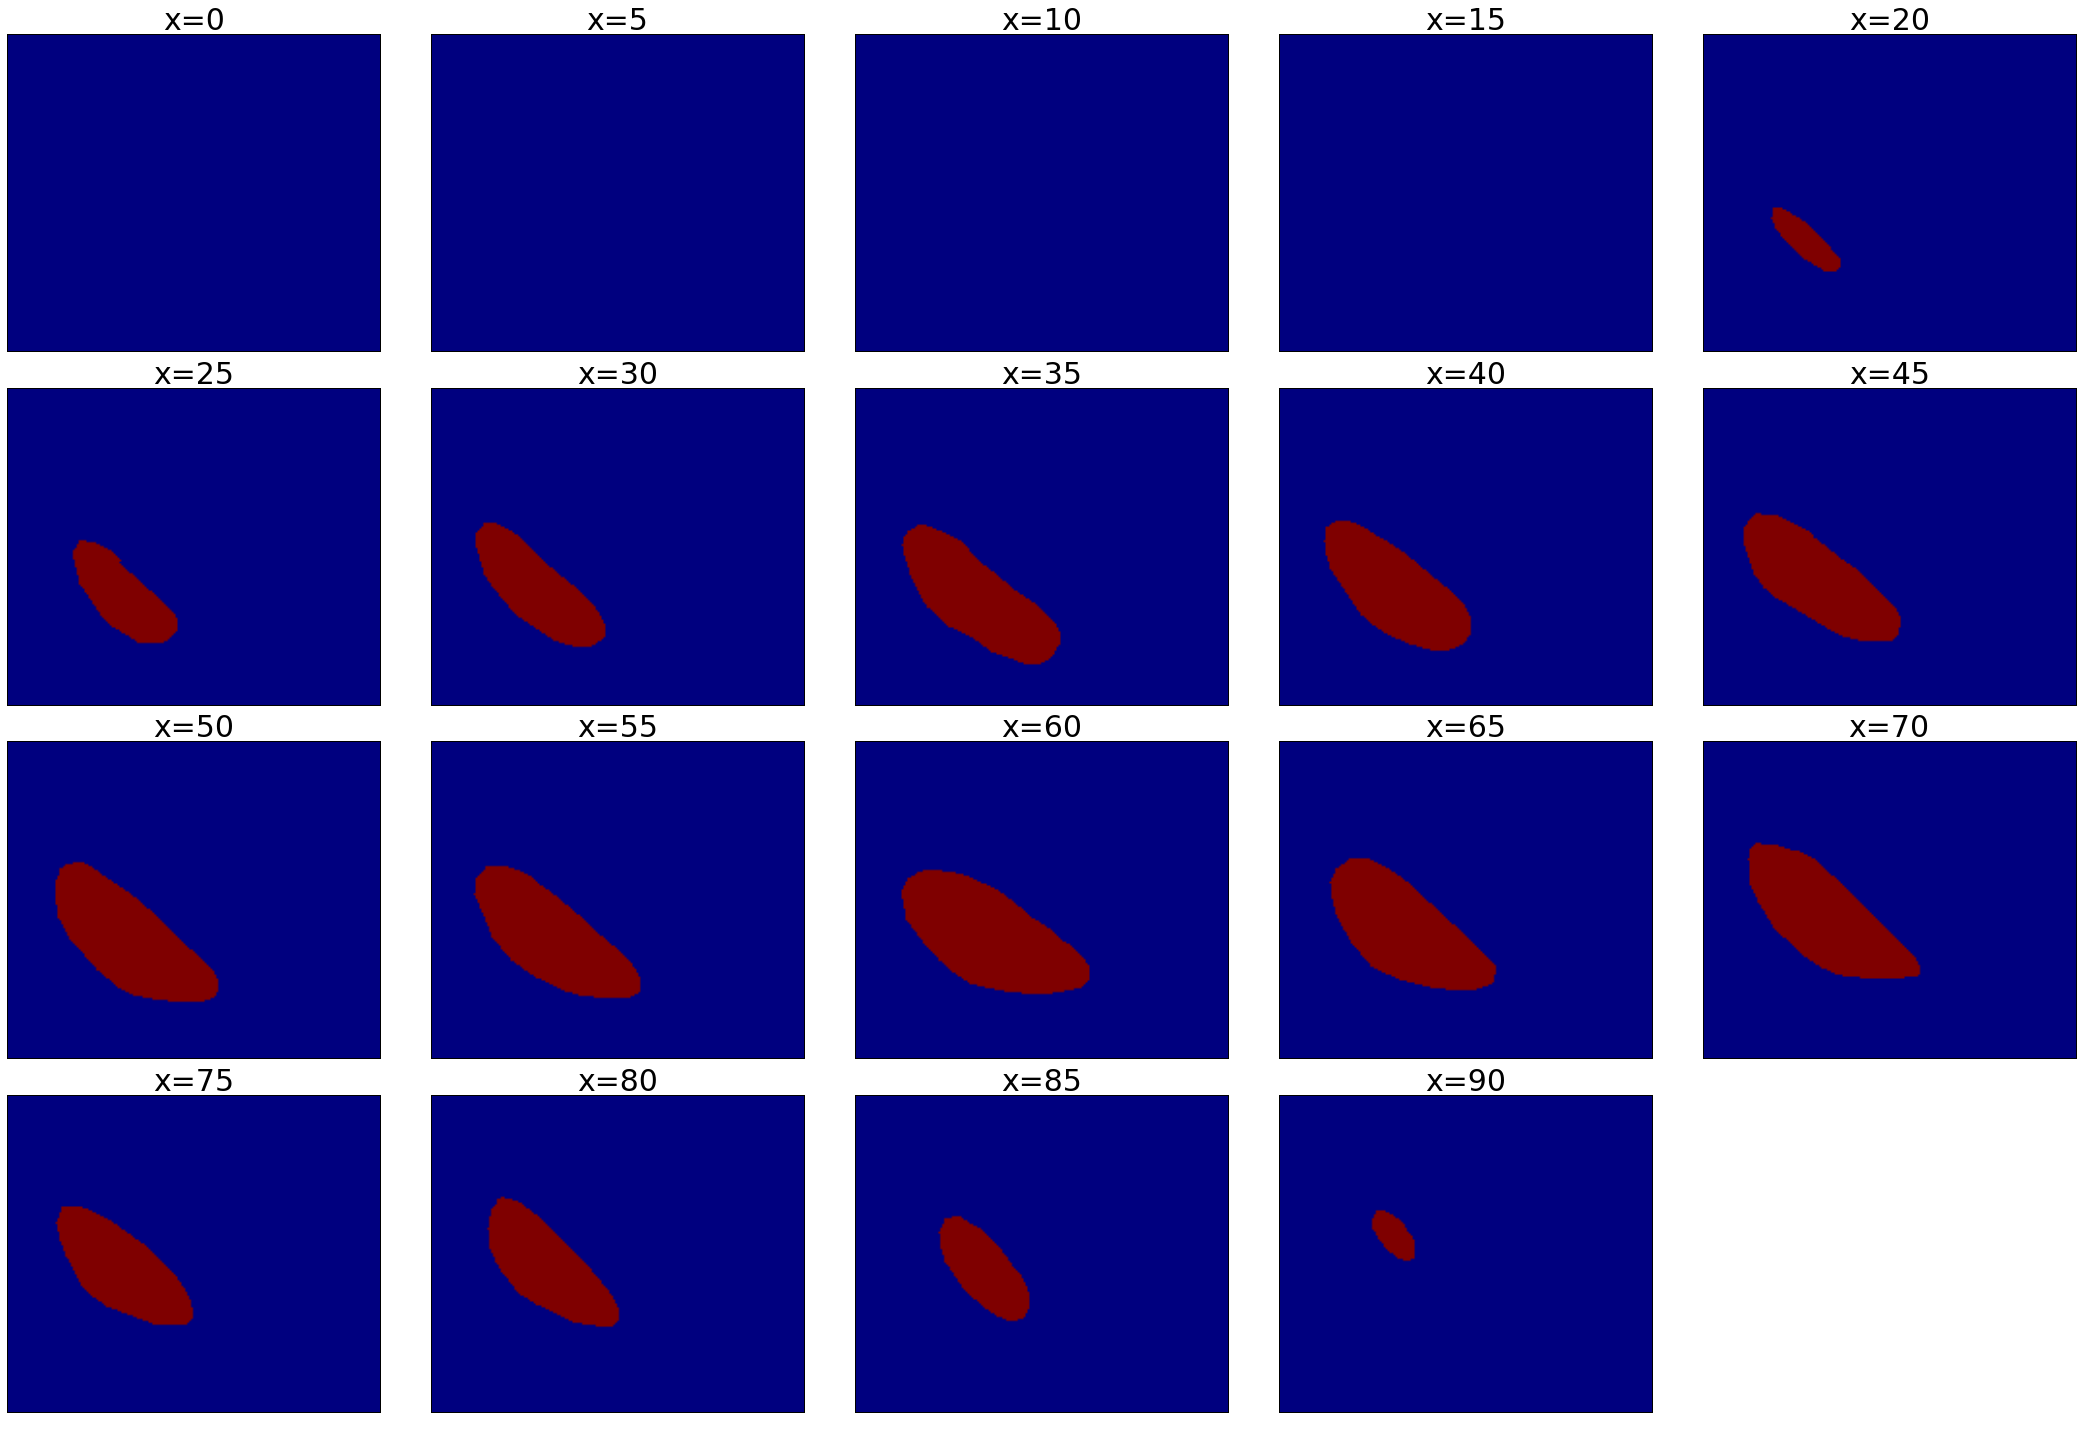

In [459]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [460]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [461]:
L = consolidate(params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)
print L

[[  9.31691892e-01  -4.22245005e-02   3.60787069e-01  -3.73464296e+00]
 [  4.58765036e-02   9.98945901e-01  -1.55985294e-03   3.43888763e+01]
 [ -3.60340900e-01   1.80049516e-02   9.32646909e-01   3.05600555e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [462]:
Q_movingvol2fixedvol = np.dot(L, G_movingvol2fixedvol - np.column_stack([np.zeros((4,3)), 
                                                  np.r_[volume_moving_bbox_rel2fixedvol[[0,2,4]], 0]]))
print Q_movingvol2fixedvol

# This is shared by all structures.
fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, volume_type='annotationAsScore', structure='SNR_L',
                                      relative_to_uncropped=True)
print fixedvol_bbox_rel2fixedsubj

Q_movingvol2fixedsubj = Q_movingvol2fixedvol + np.column_stack([np.zeros((4,3)),
                                                                np.r_[fixedvol_bbox_rel2fixedsubj[[0,2,4]], 0]])
print Q_movingvol2fixedsubj

[[  9.12045503e-01   3.53227586e-02   3.16632223e-01  -2.57281276e+01]
 [  4.57051761e-02   1.02191615e+00  -1.00678887e-01  -1.07335407e+02]
 [ -2.48856172e-01  -1.15711486e-01   9.95067755e-01   8.46195405e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[ -19   93 1132 1295 5923 6115]
[[  9.12045503e-01   3.53227586e-02   3.16632223e-01  -4.47281276e+01]
 [  4.57051761e-02   1.02191615e+00  -1.00678887e-01   1.02466459e+03]
 [ -2.48856172e-01  -1.15711486e-01   9.95067755e-01   5.93146195e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [463]:
# pts_rel2fixedsubj = np.array([[   28.5326087 ,   801.51154891,  1332.56657609]])
# pts_rel2movingvol = np.dot(np.linalg.inv(Q_movingvol2fixedsubj), 
#              np.column_stack([pts_rel2fixedsubj, np.ones((len(pts_rel2fixedsubj),))]).T).T[:, :3]

# print pts_rel2movingvol

In [464]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving_in_bboxrel2fixedvol[structure_to_label_moving[structure]]

volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

print volume_m2fl_bbox_rel2fixedvol

(7, 97, 40, 146, 14, 112)


In [465]:
# x1f,x2f,y1f,y2f,z1f,z2f = bbox_3d(volume_fixed[structure_to_label_fixed[structure]])
# sf = np.count_nonzero(volume_fixed[structure_to_label_fixed[structure]])

# plt.plot([np.count_nonzero(volume_m_alignedTo_f > t) for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=sf, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Volume');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[1] - bbox_3d(volume_m_alignedTo_f > t)[0] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=x2f+1-x1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size x');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[3] - bbox_3d(volume_m_alignedTo_f > t)[2] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=y2f+1-y1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size y');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[5] - bbox_3d(volume_m_alignedTo_f > t)[4] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=z2f+1-z1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size z');
# plt.show();

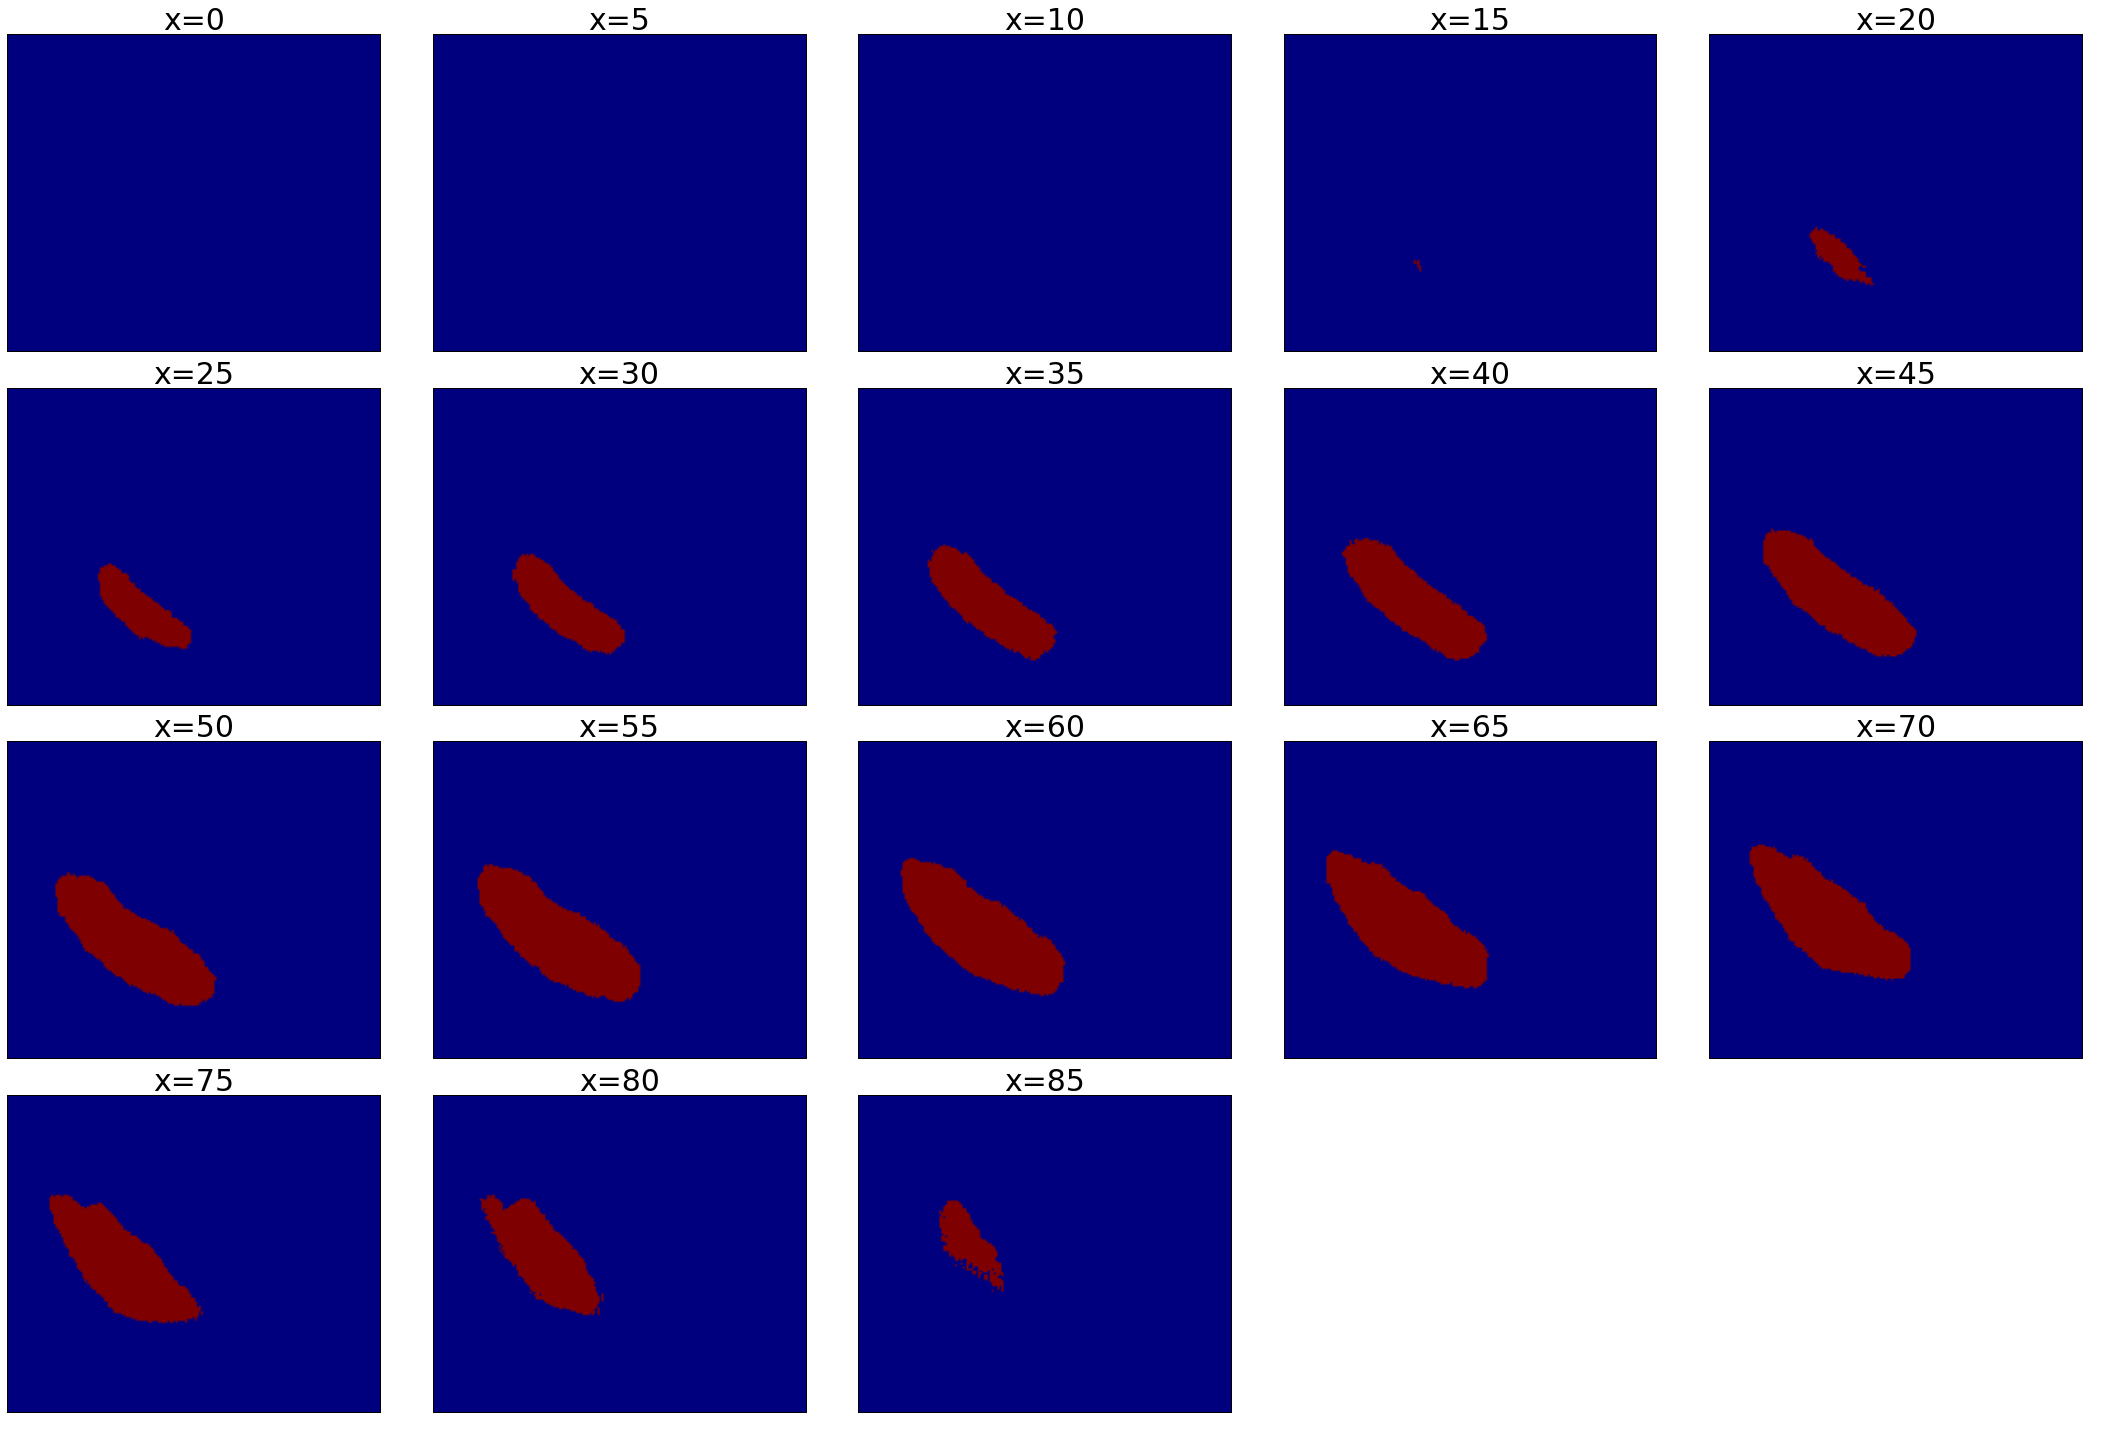

In [466]:
display_volume_sections(crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [467]:
# Warping all atlas structures.

volume_m2fl = {}
for label_m, vol_m in volume_moving_in_bboxrel2fixedvol.iteritems():
    
    volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
    transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fl[label_m] = crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

# draw

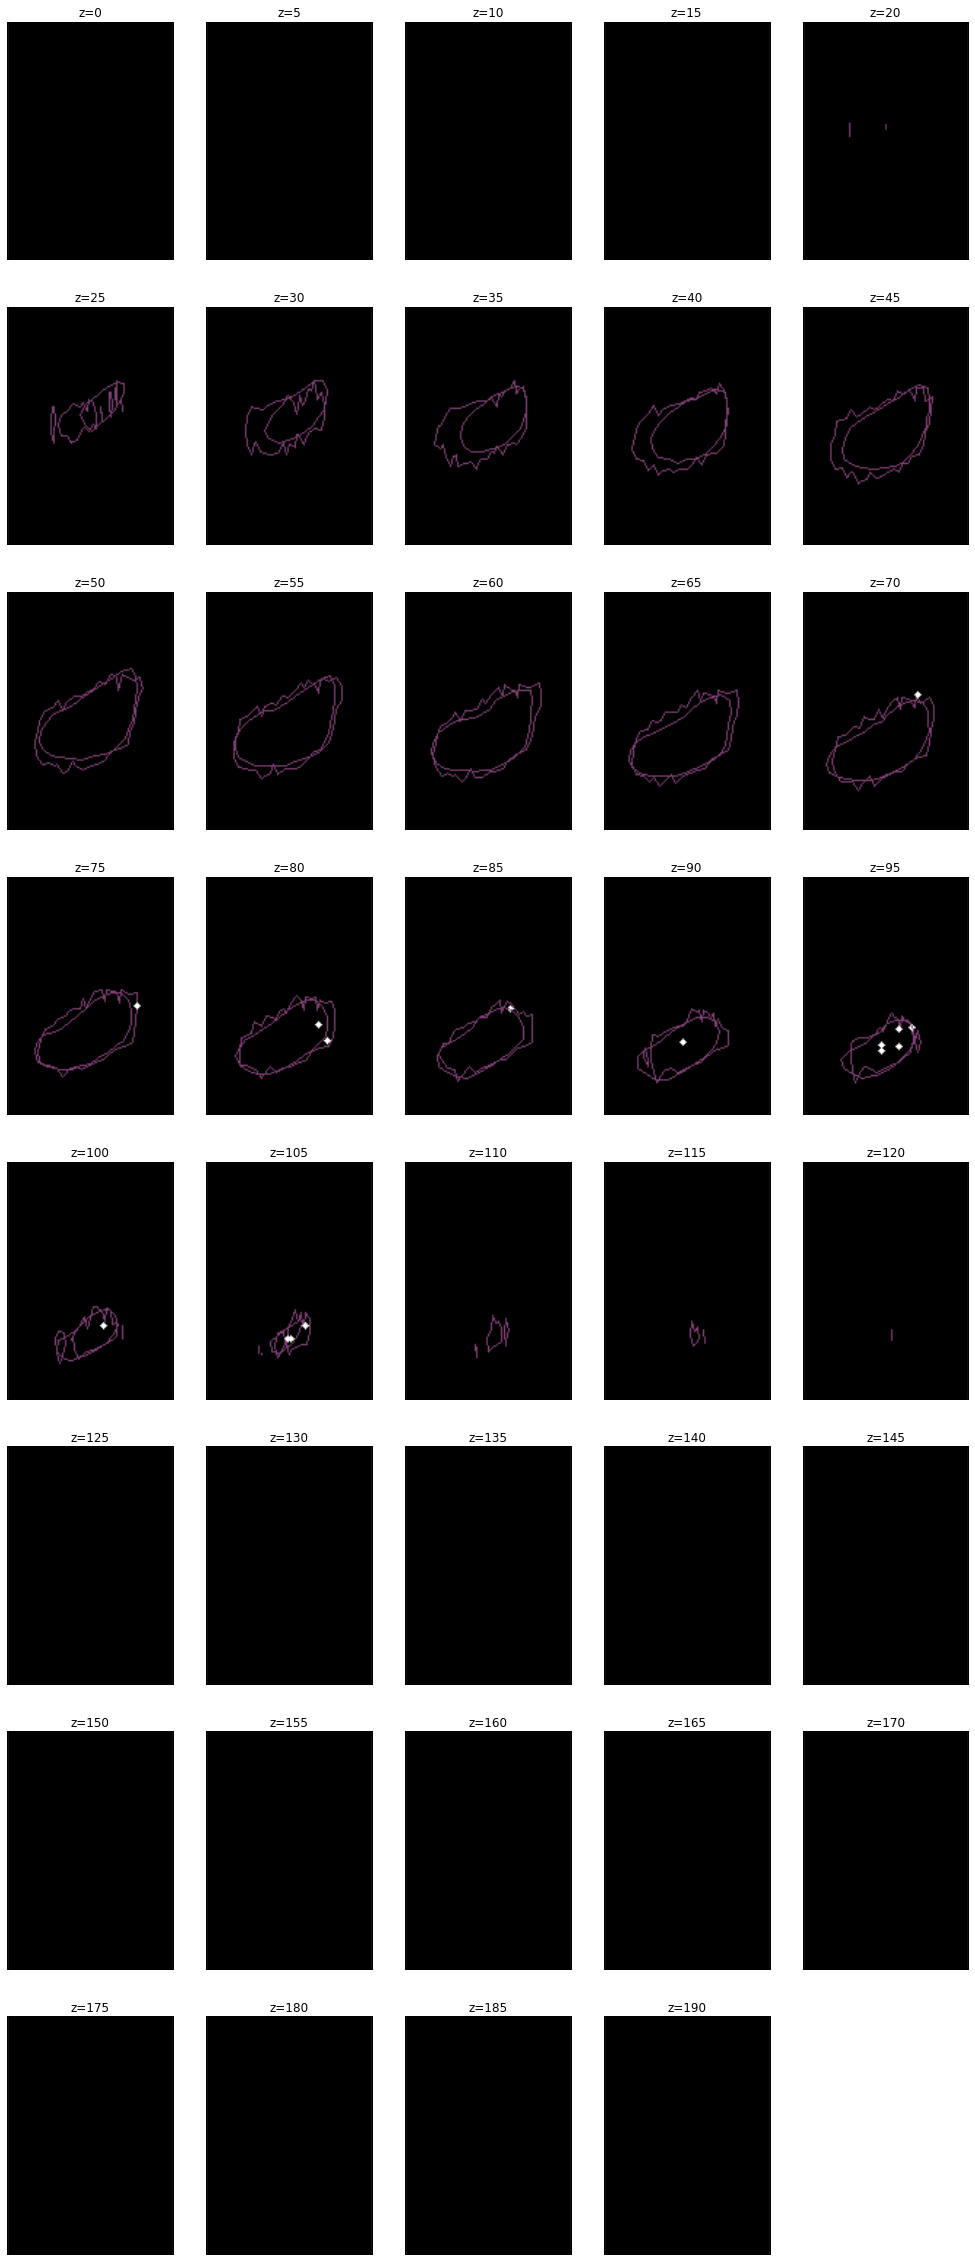

In [468]:
structures_to_draw = [l for l in volume_m2fl.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fl, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values()))

In [469]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_parameters.txt"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/home/yuncong/C